In [1]:
import re
import random

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cosine
from scipy.stats import entropy

# Reading and Preprocessing Data

The radius for Ripley's \( k \) is calculated using the following formula:
$$ r = \text{grid\_size} \times \frac{\sqrt{2}}{3} $$
Hence, the following table:

| grid_size | r   |
|-----------|-----|
| 250       | 117 |
| 125       | 58  |
| 62.5      | 30  |
| 50        | 23  |
| 31.25     | 14  |


In [2]:
def convert_string_to_np(string):
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", string)
    float_numbers = [float(num) for num in numbers]
    size = int(np.sqrt(len(float_numbers)))
    return np.array(float_numbers).reshape((size, size))

In [3]:
def preprocess_df (df):
    df['y'] = df['y'].apply(lambda x: convert_string_to_np(x))
    df['y_hat'] = df['y_hat'].apply(lambda x: convert_string_to_np(x))
    df['grid_num'] = df['grid_num'].apply(lambda x: int(x.split('_')[0]))
    if 'subset' in df.columns:
        df['subset'] = df['subset'].apply(lambda x: list(eval(x)))
    return df

In [4]:
main_df = preprocess_df(pd.read_csv('main.csv'))
case_df = preprocess_df(pd.read_csv('case.csv'))
control_df = preprocess_df(pd.read_csv('control.csv'))

# Main Analysis

## Performance Measures

In [5]:
def calculate_performance(row):
    y = row['y']
    y_hat = row['y_hat']
    total_active_cells = row['total_active_cells']
    
    output = {
        'mae': dict(),
        'rmse': dict(),
        'r2': dict(),
        'kl_divergence': dict(),
    }

    AP_sum_true = np.sum(y, axis=1)
    AP_sum_pred = np.sum(y_hat, axis=1)
    
    DV_sum_true = np.sum(y, axis=0)
    DV_sum_pred = np.sum(y_hat, axis=0)

    # Mean Absolute Error
    output['mae']['grid'] = np.mean(np.abs(y - y_hat))
    output['mae']['AP'] = np.mean(np.abs(AP_sum_true - AP_sum_pred))
    output['mae']['DV'] = np.mean(np.abs(DV_sum_true - DV_sum_pred))

    # Root Mean Squared Error
    output['rmse']['grid'] = np.sqrt(mean_squared_error(y, y_hat))
    output['rmse']['AP'] = np.sqrt(mean_squared_error(AP_sum_true, AP_sum_pred))
    output['rmse']['DV'] = np.sqrt(mean_squared_error(DV_sum_true, DV_sum_pred))
    
    # R-squared
    output['r2']['grid'] = r2_score(y, y_hat)
    output['r2']['AP'] = r2_score(AP_sum_true, AP_sum_pred)
    output['r2']['DV'] = r2_score(DV_sum_true, DV_sum_pred)
    
    # KL Divergence - first ensure no zero values and normalize to create distributions
    epsilon = 1e-10
    grid_true = (y + epsilon) / (np.sum(y) + epsilon * len(y))
    grid_pred = (y_hat + epsilon) / (np.sum(y_hat) + epsilon * len(y_hat))
    
    AP_sum_true = (AP_sum_true + epsilon) / (np.sum(AP_sum_true) + epsilon * len(AP_sum_true))
    AP_sum_pred = (AP_sum_pred + epsilon) / (np.sum(AP_sum_pred) + epsilon * len(AP_sum_pred))
    
    DV_sum_true = (DV_sum_true + epsilon) / (np.sum(DV_sum_true) + epsilon * len(DV_sum_true))
    DV_sum_pred = (DV_sum_pred + epsilon) / (np.sum(DV_sum_pred) + epsilon * len(DV_sum_pred))

    output['kl_divergence']['grid'] = np.mean(entropy(grid_true, grid_pred))
    output['kl_divergence']['AP'] = entropy(AP_sum_true, AP_sum_pred)
    output['kl_divergence']['DV'] = entropy(DV_sum_true, DV_sum_pred)

    return output

In [6]:
performance_metrics = ['mae', 'rmse', 'r2', 'kl_divergence']

for metric in performance_metrics:
    main_df[f"grid_{metric}"] = main_df.apply(lambda x: calculate_performance(x)[metric]['grid'], axis=1)
    main_df[f"AP_{metric}"] = main_df.apply(lambda x: calculate_performance(x)[metric]['AP'], axis=1)
    main_df[f"DV_{metric}"] = main_df.apply(lambda x: calculate_performance(x)[metric]['DV'], axis=1)

## Plots

In [7]:
selected_columns = ['video_id', 'grid_num', 'AP_mae', 'DV_mae', 'AP_rmse', 'DV_rmse', 'AP_kl_divergence', 'DV_kl_divergence']
selected_df = main_df[main_df['grid_num'] == 16]
selected_df = selected_df[selected_columns]
selected_df['mean_mae'] = (selected_df['AP_mae'] + selected_df['DV_mae']) / 2
selected_df['mean_rmse'] = (selected_df['AP_rmse'] + selected_df['DV_rmse']) / 2

In [8]:
selected_df.groupby(['video_id']).mean().sort_values(by='mean_mae')

,grid_num,AP_mae,DV_mae,AP_rmse,DV_rmse,AP_kl_divergence,DV_kl_divergence,mean_mae,mean_rmse
video_id,,,,,,,,,
control_sog_d_5,16.0,2.731352,3.203416,4.298548,3.835598,0.032749,0.034136,2.967384,4.067073
control_sog_d_6,16.0,3.093720,2.847606,4.564737,3.417233,0.067203,0.074592,2.970663,3.990985
control_sog_d_2,16.0,3.885839,3.310820,5.920863,3.882076,0.167801,0.100592,3.598329,4.901469
control_sog_d_9,16.0,3.351591,3.858545,4.819906,4.596095,0.050364,0.108986,3.605068,4.708001
control_sog_d_1,16.0,4.032530,4.146022,5.645577,4.796841,0.100247,0.124584,4.089276,5.221209
control_sog_d_3,16.0,4.896062,5.250043,6.684616,5.806666,0.150584,0.110636,5.073052,6.245641
control_sog_d_8,16.0,5.850748,5.368763,8.305328,6.151566,0.046122,0.032921,5.609756,7.228447
control_sog_d_7,16.0,6.849494,5.549404,9.228026,6.226990,0.127654,0.046558,6.199449,7.727508
control_sog_d_4,16.0,6.908862,6.737027,9.366913,7.295683,0.053309,0.019965,6.822944,8.331298


In [9]:
selected_df.groupby(['video_id']).mean().sort_values(by='mean_rmse')

,grid_num,AP_mae,DV_mae,AP_rmse,DV_rmse,AP_kl_divergence,DV_kl_divergence,mean_mae,mean_rmse
video_id,,,,,,,,,
control_sog_d_6,16.0,3.093720,2.847606,4.564737,3.417233,0.067203,0.074592,2.970663,3.990985
control_sog_d_5,16.0,2.731352,3.203416,4.298548,3.835598,0.032749,0.034136,2.967384,4.067073
control_sog_d_9,16.0,3.351591,3.858545,4.819906,4.596095,0.050364,0.108986,3.605068,4.708001
control_sog_d_2,16.0,3.885839,3.310820,5.920863,3.882076,0.167801,0.100592,3.598329,4.901469
control_sog_d_1,16.0,4.032530,4.146022,5.645577,4.796841,0.100247,0.124584,4.089276,5.221209
control_sog_d_3,16.0,4.896062,5.250043,6.684616,5.806666,0.150584,0.110636,5.073052,6.245641
control_sog_d_8,16.0,5.850748,5.368763,8.305328,6.151566,0.046122,0.032921,5.609756,7.228447
control_sog_d_7,16.0,6.849494,5.549404,9.228026,6.226990,0.127654,0.046558,6.199449,7.727508
control_sog_d_4,16.0,6.908862,6.737027,9.366913,7.295683,0.053309,0.019965,6.822944,8.331298


In [10]:
stage_dict = {
    'nc_13_late': 'Stage NC 13 Late',
    'nc_14_a': 'Stage NC 14 A',
    'nc_14_b': 'Stage NC 14 B',
    'nc_14_c': 'Stage NC 14 C',
    'nc_14_d': 'Stage NC 14 D',
    'stage_6': 'Stage 6',
}

video_id_dict = {
    'control_sog_d_6': 'Best',
    'control_sog_d_1': 'Median',
    'control_sog_d_4': 'Worst',
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


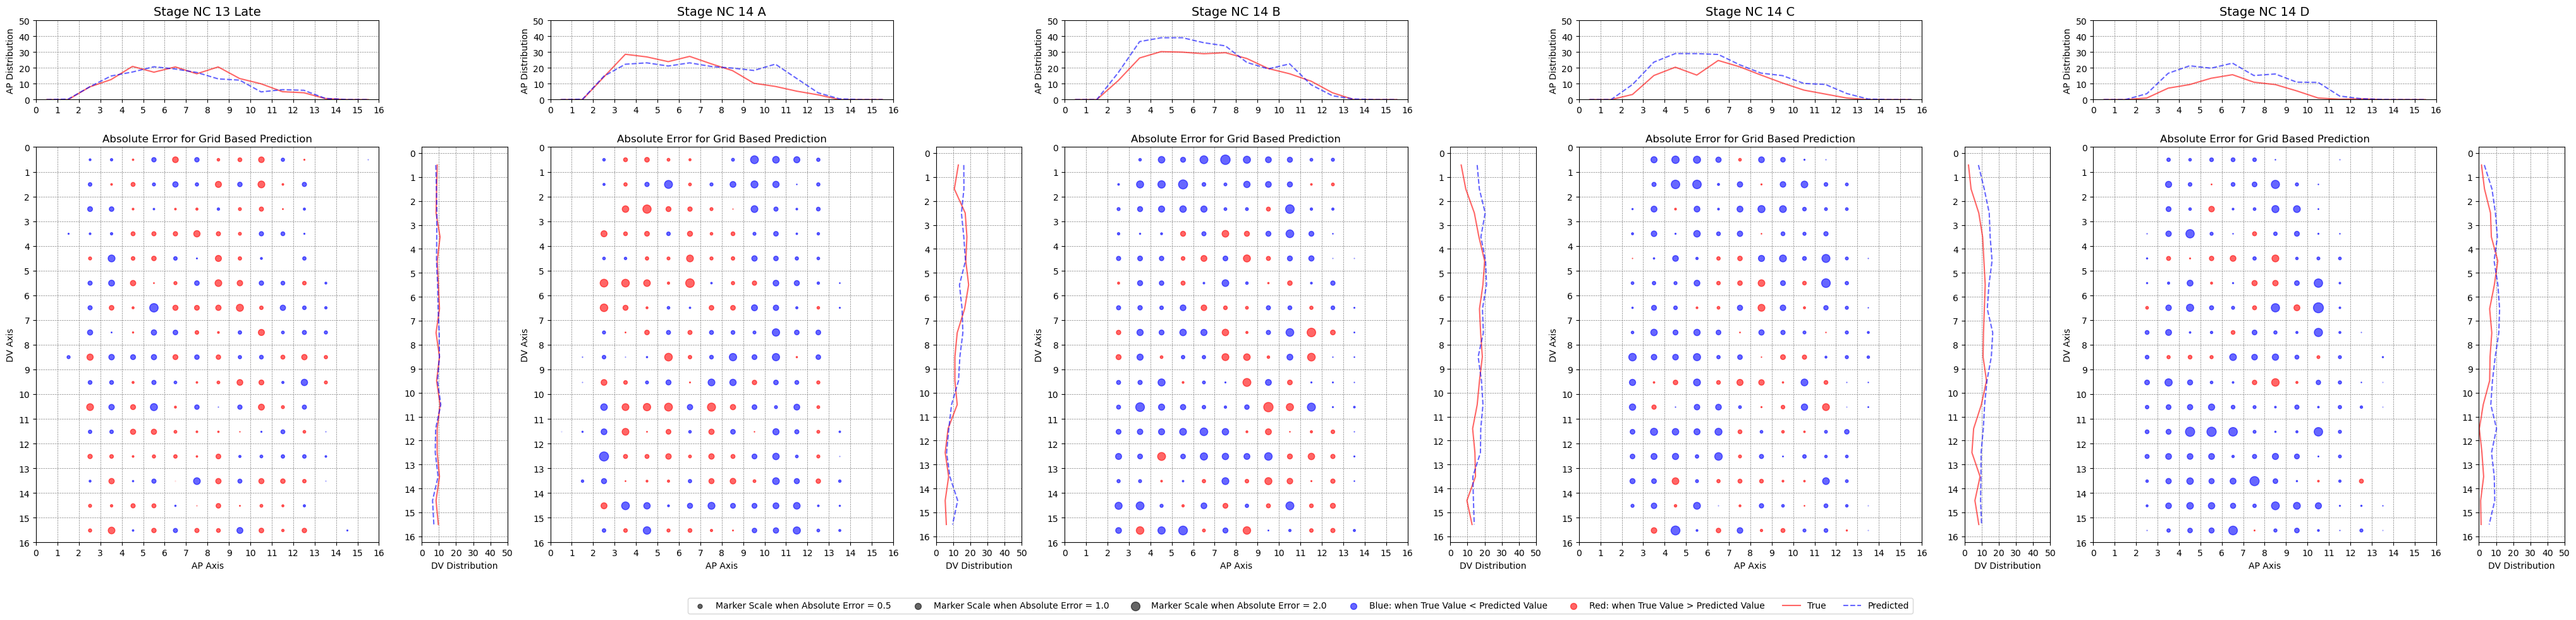

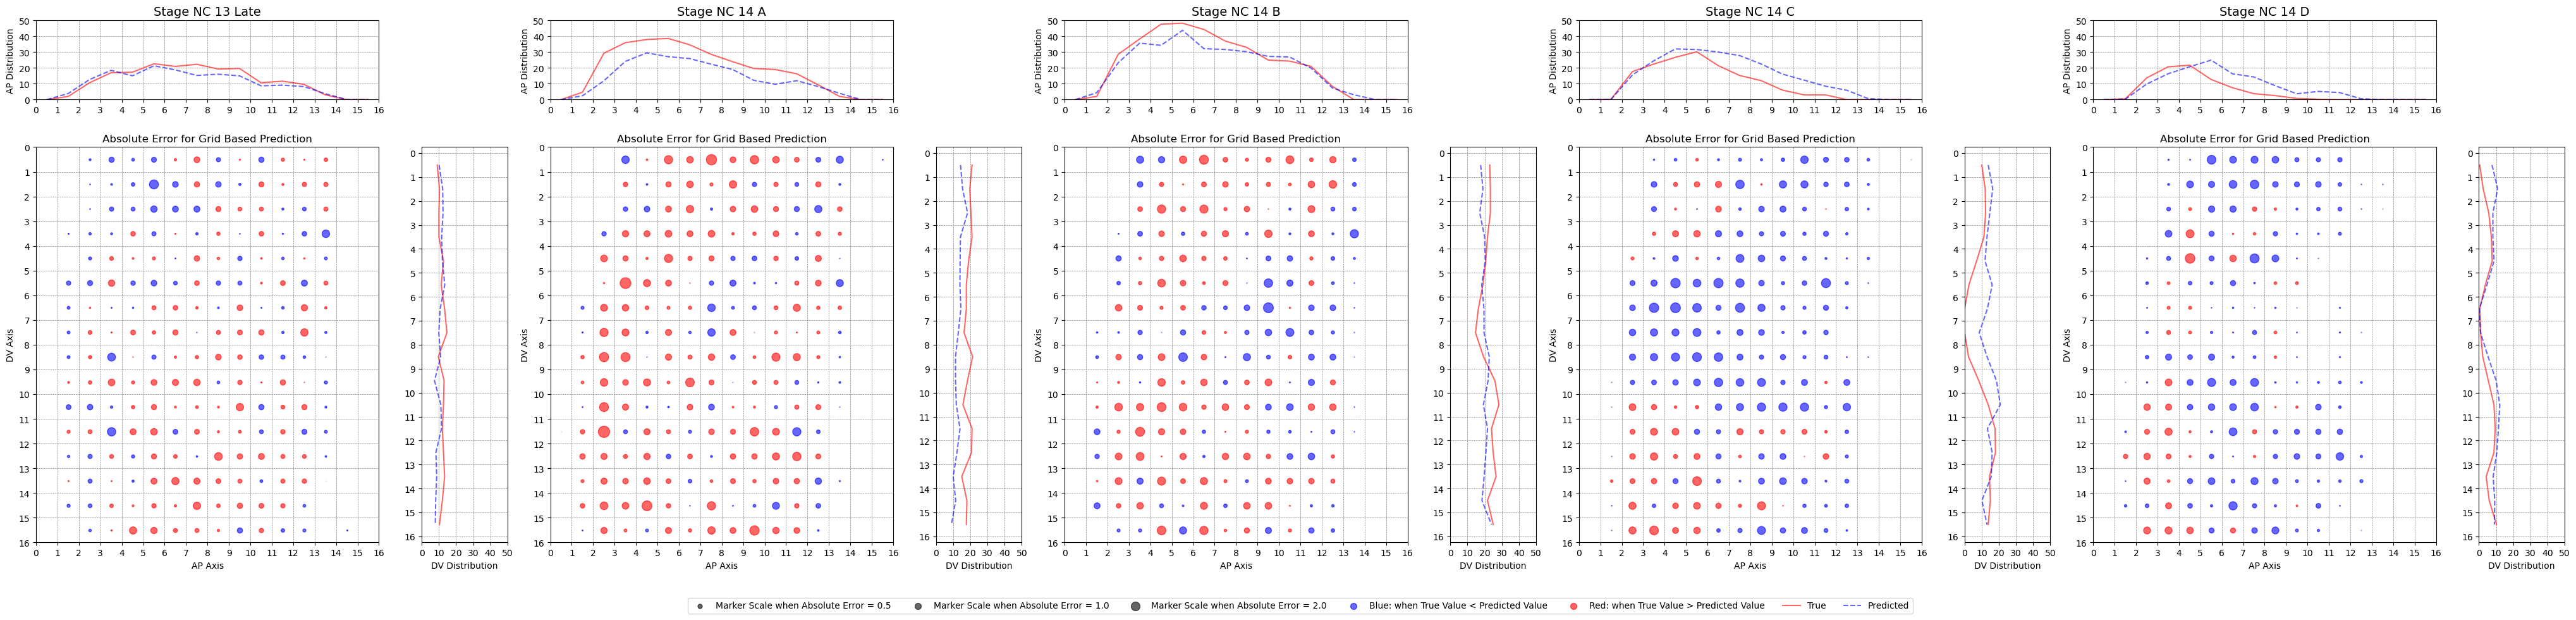

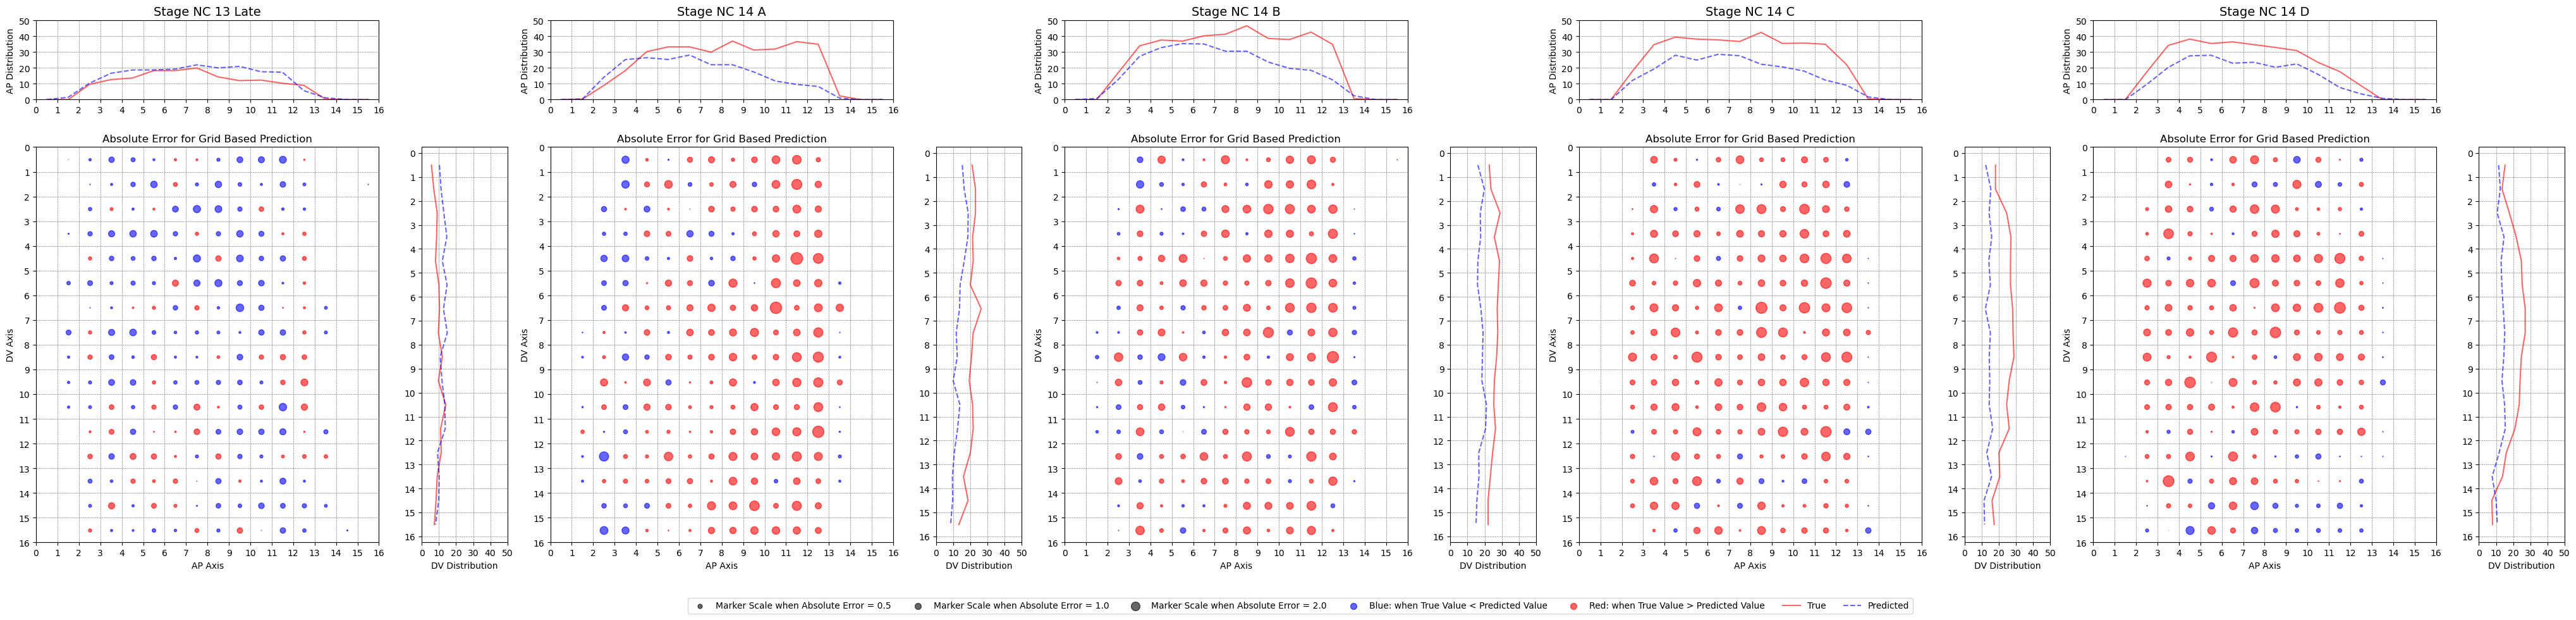

In [11]:
for video_id in ['control_sog_d_6', 'control_sog_d_1', 'control_sog_d_4']:
    data = main_df[main_df['video_id'] == video_id]
    data = data[data['grid_num'] == 16]
    
    stages = data['stage'].unique()
    stages = [stage for stage in stages if stage not in ['stage_6']]
    n_stages = len(stages)

    fig = plt.figure(figsize=(n_stages * 10, 10))  # Adjust figsize as needed
    gs = fig.add_gridspec(2, n_stages * 2, width_ratios=n_stages * (4, 1), height_ratios=(1, 5), left=0.1, right=0.9, bottom=0.1, top=0.925, wspace=0.2, hspace=0.2)

    for stage_idx, stage in enumerate(stages):
        stage_data = data[data['stage'] == stage]

        for index, row in stage_data.iterrows():
            y = row['y'][::-1]
            y_hat = row['y_hat'][::-1]

            differences = np.abs(y - y_hat)
            colors = np.where(y > y_hat, 'red', 'blue')

            actual_horizontal_dist = y.sum(axis=1)
            predicted_horizontal_dist = y_hat.sum(axis=1)

            actual_vertical_dist = y.sum(axis=0)
            predicted_vertical_dist = y_hat.sum(axis=0)

            # Define subplots for this stage
            ax_scatter = fig.add_subplot(gs[1, stage_idx*2])
            ax_histx = fig.add_subplot(gs[0, stage_idx*2], sharex=ax_scatter)
            ax_histy = fig.add_subplot(gs[1, stage_idx*2+1])

            # Scatter plot with varying point sizes and colors
            for (i, j), value in np.ndenumerate(differences):
                ax_scatter.scatter(i+0.5, j+0.5, s=value * 50, c=colors[i, j], alpha=0.6)
            
            ax_scatter.set_xlim(0, 16)
            ax_scatter.set_ylim(0, 16)
            ax_scatter.invert_yaxis()  # Reverse the y-axis in ax_scatter
            ax_scatter.set_xlabel('AP Axis')
            ax_scatter.set_ylabel('DV Axis')
            ax_scatter.set_title('Absolute Error for Grid Based Prediction')
            
            # Adding 1 by 1 grid lines to the scatter plot
            ax_scatter.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
            ax_scatter.set_xticks(np.arange(0, 17, 1))
            ax_scatter.set_yticks(np.arange(0, 17, 1))
            
            # Horizontal distribution comparison (top)
            ax_histx.plot(np.arange(0.5, 16.5), actual_horizontal_dist, alpha=0.6, label='True', linestyle='-', c='r')
            ax_histx.plot(np.arange(0.5, 16.5), predicted_horizontal_dist, alpha=0.6, label='Predicted', linestyle='--', c='b')
            ax_histx.set_ylim(0, 50)
            ax_histx.set_yticks(np.arange(0, 51, 10))
            ax_histx.set_ylabel('AP Distribution')
            ax_histx.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
            ax_histx.set_title(f'{stage_dict[stage]}', fontsize=14)
            
            # Vertical distribution comparison (right)
            ax_histy.plot(actual_vertical_dist, np.arange(0.5, 16.5), alpha=0.6, label='True', linestyle='-', c='r')
            ax_histy.plot(predicted_vertical_dist, np.arange(0.5, 16.5), alpha=0.6, label='Predicted', linestyle='--', c='b')
            ax_histy.set_xlim(0, 50)
            ax_histy.set_xticks(np.arange(0, 51, 10))
            ax_histy.set_yticks(np.arange(0, 17, 1))
            ax_histy.invert_yaxis()  # Reverse the y-axis in ax_histy
            ax_histy.set_xlabel('DV Distribution')
            ax_histy.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)

    # Create sample points for the legend
    for size in [25, 50, 100]:  # Example sizes
        ax_scatter.scatter([], [], c='black', alpha=0.6, s=size, label=f'Marker Scale when Absolute Error = {size / 50}')
    ax_scatter.scatter([], [], c='blue', alpha=0.6, s=50, label=f'Blue: when True Value < Predicted Value')
    ax_scatter.scatter([], [], c='red', alpha=0.6, s=50, label=f'Red: when True Value > Predicted Value')
    ax_scatter.plot([], [], alpha=0.6, label='True', linestyle='-', c='r')
    ax_scatter.plot([], [], alpha=0.6, label='Predicted', linestyle='--', c='b')

    handles, labels = ax_scatter.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center', scatterpoints=1, frameon=True, ncol=7, bbox_to_anchor=(0.5, 0))
    
    # fig.suptitle(f"Test Sample with the {video_id_dict[video_id]} Performance According to Prediction Mean MAE Across Stages and Axes", fontsize=18)
    plt.savefig(f"{video_id_dict[video_id]}.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{video_id_dict[video_id]}.eps", dpi=300, bbox_inches='tight')